In [36]:
import pandas as pd
import numpy as np
# import tensorflow as tf
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib as mtlib
import matplotlib.pyplot as plt
import scipy
import re
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.model_selection import train_test_split
from matplotlib import cm
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc


In [2]:
#question 1:
# please add your path here to see what it means
path = "C:\\Users\\user\\LoanStats3c.xlsx"
df = pd.read_excel(path)

# Part A

## 	1. Explore the data set

#### some basic statistics about the data:

let's explore the dataset dimentions

In [3]:
num_rows = df.shape[0]
num_cols = df.shape[1]
print(num_rows,num_cols)

161231 52


we can see that the dataset consists of 161,231 rows and 53 columns (features).

now we wish to explore the types of data each feature describes.

In [4]:
df.dtypes

id                                      int64
member_id                               int64
loan_amnt                               int64
funded_amnt                             int64
funded_amnt_inv                         int64
term                                   object
int_rate                              float64
installment                           float64
grade                                  object
sub_grade                              object
emp_title                              object
emp_length                             object
home_ownership                         object
annual_inc                            float64
is_inc_v                               object
issue_d                        datetime64[ns]
loan_status                            object
pymnt_plan                             object
url                                    object
desc                                   object
purpose                                object
title                             

In [5]:
df_numeric = df.select_dtypes(exclude=['object','datetime64[ns]'])
df_categorical = df.select_dtypes(include=['object'])
df_dates = df.select_dtypes(include=['datetime64[ns]'])
print(df_numeric.shape[1],df_categorical.shape[1],df_dates.shape[1])

31 16 5


after I evaluated the LCDDataDictionary and explored the diffrent dataFrames above that was generated to fit a specific data type,

I can say that the data consists of:

1. 28 numerical features

2. 17 categorical features

3. 5 date features

## 	2.	Descriptive statistics

in order to explore the data and to understand which feature to choose and to analyze, i done some data cleansing so i could see the data compleatly

###### Data Cleansing for A.2 mission:


In [6]:
df["mths_since_last_delinq"] = df["mths_since_last_delinq"].fillna(0)
df["mths_since_last_record"] = df["mths_since_last_record"].fillna(0)
df["mths_since_last_major_derog"] = df["mths_since_last_major_derog"].fillna(0)
df["last_credit_pull_d"]  = df["last_credit_pull_d"].fillna(0)
df["last_pymnt_d"]  = df["last_pymnt_d"].fillna(0)
df["next_pymnt_d"]  = df["next_pymnt_d"].fillna(0)
df["revol_util"]  = df["revol_util"].fillna(0)
df["desc"]  = df["desc"].fillna('no')
df["emp_title"]  = df["emp_title"].fillna("0")
#fixing the data: term columns
df = df.apply(lambda row: row.str.split(' ',expand=True)[1] if row.name=="term" else row,axis=0)

after carfuley viewing the data i choose to show descriptive analysis of the following 3 features:

1. int_rate
2. term
3. loan_amnt


int_rate - distribution: 


skewness    0.3517365179375381
kurtosis    -0.11390647151600275
 count    161231.000000
mean          0.140575
std           0.043267
min           0.060000
25%           0.109900
50%           0.139800
75%           0.165900
max           0.260600
Name: int_rate, dtype: float64


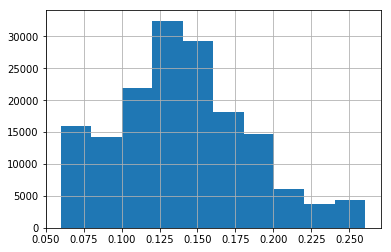

In [7]:
feature = "int_rate"
print("{} - distribution: \n\n".format(feature))
print("skewness    {}\nkurtosis    {}\n".format(df[feature].skew(),df[feature].kurtosis()),df[feature].describe())
df[feature].hist()
plt.show()

we can see that the <b>int_rate</b> feature has a small right tail as shown by the small positve kurtosis, forther more we can see that int_rate is continues.

term - distribution: 


count     161231
unique         2
top           36
freq      112374
Name: term, dtype: object


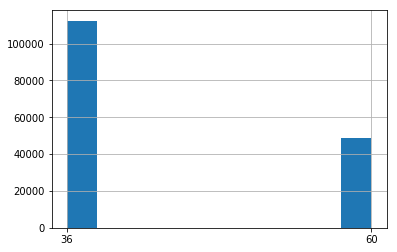

In [8]:
feature = "term"
print("{} - distribution: \n\n".format(feature))
print(df[feature].describe())
df[feature].hist()
plt.show()

we can see that the term feature is binary feature with values 36 and 60, it's a discrite feature.

loan_amnt - distribution: 


skewness    0.7144219509955008
kurtosis    -0.2177389643914025
 count    161231.000000
mean      14864.642190
std        8412.637516
min        1000.000000
25%        8400.000000
50%       13000.000000
75%       20000.000000
max       35000.000000
Name: loan_amnt, dtype: float64


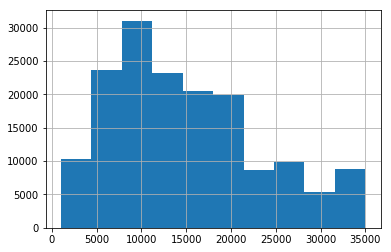

In [9]:
feature = "loan_amnt"
print("{} - distribution: \n\n".format(feature))
print("skewness    {}\nkurtosis    {}\n".format(df[feature].skew(),df[feature].kurtosis()),df[feature].describe())
df[feature].hist()
plt.show()

we can see that the <b>loan_amnt</b> feature has a right tail as shown by the positve kurtosis, forther more we can see that loan_amnt is continues.<br>
and that the mode, median and mean are pretty diffrent witch means that the distribution is asimetric.

## 3. Define a business problem

after exploring the data set we saw that we could try to predict if a specific loaner will have a 30+ days past-due incidences 
of delinquency in the borrower's credit file for the next 2 years.<br>therefore, for any new observation regarding the borower with data which aprior to the loan period we would try to predict the chances for a delinquecy for the next 2 years.

## 4. Present a simple analysis

<b>4.1. Target/label:</b> i turend the feature <b>delinq_2yrs</b> to a binary feature as a label to predict
, has shown below:

In [10]:
df["Target"] = df["delinq_2yrs"].apply(lambda col: 1 if col > 0 else 0) 

I had to examine the data to find the perfect features to solve the bussiness problem there for i looked for correlations between the target and the other features<br>in the case of the categorical and the dates type features i turned them to a numeric numianl values. i was carfuel to choose features that are not created after the loan was ended because i'm tring to predict if the owner will have delinquency during his loan.

#### transforming the categorical feaures:

In [11]:
d = defaultdict(LabelEncoder)
df_categorical_copy = df_categorical.copy(deep=True)
df_categorical_copy = df_categorical_copy.drop(["emp_title","desc"],axis=1)
fit = df_categorical_copy.apply(lambda x: d[x.name].fit_transform(x))
df_categorical_copy = fit
df_categorical_copy["Target"] = df["Target"]

#### transforming the dates feaures:

In [12]:
d = defaultdict(LabelEncoder)
df_dates_copy = df_dates.copy(deep=True)
df_dates_copy = df_dates_copy
fit = df_dates_copy.apply(lambda x: d[x.name].fit_transform(x))
df_dates_copy = fit
df_dates_copy["Target"] = df["Target"]

C:\Users\user\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:279: FutureWarning: In the future, NAT != NAT will be True rather than False.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


#### puting the Target label in the numeric features dataset:

In [13]:
df_numeric["Target"] = df["Target"]
print("percent of end points is: {0:.2f}%".format(sum(df["Target"])/len(df)*100))

percent of end points is: 20.56%


#### finding the correlations between the features to extract the best features:

I finding correlations according to the spearman method for the categoric featues because they are numianl
for the dates and the numerical features i'm finding the correlation according to pearson method, because they are ordinal features

In [14]:
cor_categor = df_categorical_copy.corr("spearman")

In [15]:
cor_date = df_dates_copy.corr("pearson")

In [16]:
cor_num = df_numeric.corr("pearson")

In [17]:
cor_categor = cor_categor["Target"].apply(lambda x: np.abs(x)).sort_values(ascending=False)

In [18]:
cor_date = cor_date["Target"].apply(lambda x: np.abs(x)).sort_values(ascending=False)

In [19]:
cor_num = cor_num["Target"].apply(lambda x: np.abs(x)).sort_values(ascending=False)

In [88]:
print("categorical: \n{}".format(cor_categor.head(10)))

categorical: 
Target            1.000000
sub_grade         0.086557
grade             0.083232
home_ownership    0.066747
emp_length        0.035337
purpose           0.034182
title             0.029262
zip_code          0.022054
is_inc_v          0.011655
url               0.007913
Name: Target, dtype: float64


<b>4.2. Two Categorical features:</b><br>
a. sub_grade<br>
b. home_ownership
<br><br>
the reason i choose sub_grade insted of grade is because grade is highly correlated with sub_grade so i wanted to avoid a case of multicolinarity

<b>a. sub_grade:</b>

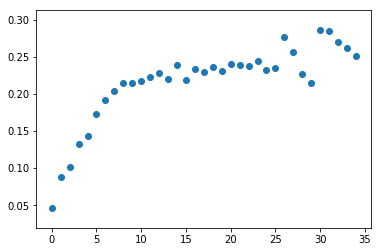

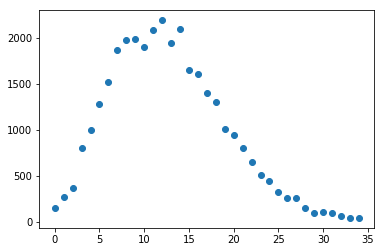

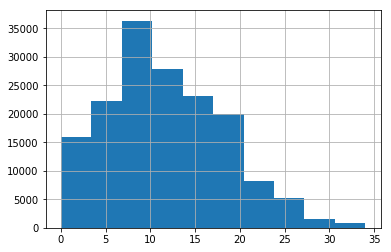

In [21]:
crosstab = pd.crosstab(index=df_categorical_copy["sub_grade"],columns=df_categorical_copy["Target"])
plt.scatter(crosstab.index,crosstab[1]/((crosstab[0]+crosstab[1])))
plt.show()
plt.scatter(crosstab.index,crosstab[1])
plt.show()
df_categorical_copy["sub_grade"].hist()
plt.show()

 we can see that according to the data it is more likley to have a delinquency if your sub_grade is higher (A1<A2...<D1)

<b>b. home_ownership:</b>

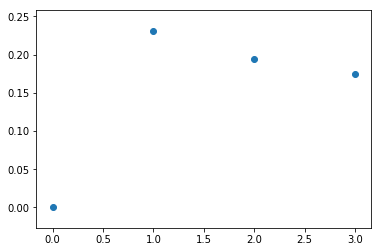

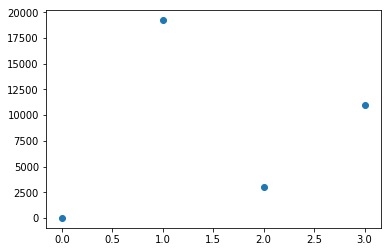

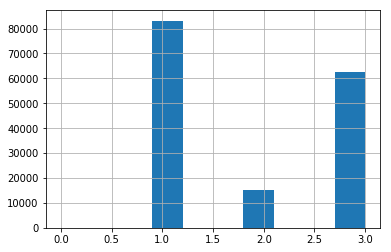

In [22]:
crosstab = pd.crosstab(index=df_categorical_copy["home_ownership"],columns=df_categorical_copy["Target"])
plt.scatter(crosstab.index,crosstab[1]/((crosstab[0]+crosstab[1])))
plt.show()
plt.scatter(crosstab.index,crosstab[1])
plt.show()
df_categorical_copy["home_ownership"].hist()
plt.show()

I noticed that the lowest amount of delinquency happpens if the owner's house is rented and the most is when the house is on mortgage, but still the varience is very low the diffrencet between the chances for every status is not high, 5%-10% absolute distance

In [87]:
print("numerical: \n{}".format(cor_num.head(9)))

numerical: 
Target                         1.000000
mths_since_last_delinq         0.787083
delinq_2yrs                    0.752830
mths_since_last_major_derog    0.518698
total_acc                      0.120609
int_rate                       0.087109
mths_since_last_record         0.058728
annual_inc                     0.057386
open_acc                       0.053354
Name: Target, dtype: float64


<b>4.3. Two Numerical features:</b><br>
a. total_acc<br>
b. annual_inc

I decided to take the annual_inc and not the int_rate because by exmening the data i saw that the int_rate and the total_acc are highly correlated, putting them in the same model would lead to a bad model fit.

<b>a. total_acc</b>

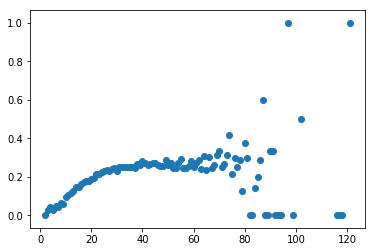

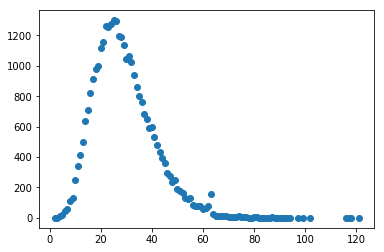

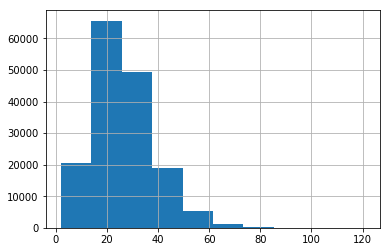

In [24]:
crosstab = pd.crosstab(index=df_numeric["total_acc"],columns=df_categorical_copy["Target"])
plt.scatter(crosstab.index,crosstab[1]/((crosstab[0]+crosstab[1])))
plt.show()
plt.scatter(crosstab.index,crosstab[1])
plt.show()
df_numeric["total_acc"].hist()
plt.show()

we can see that the delinquency rate is uniform for a total_acc value which is above 30 and under 70 after and before its close to zero, this means that there is no real diffrence between the most common values in terms of the delinquency rate in the population

<b>b. annual_inc</b>

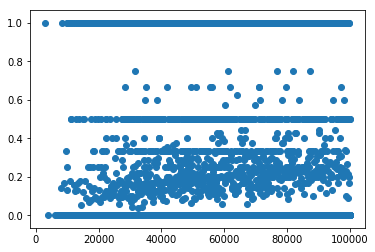

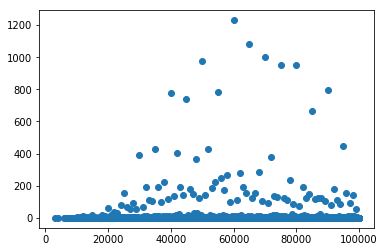

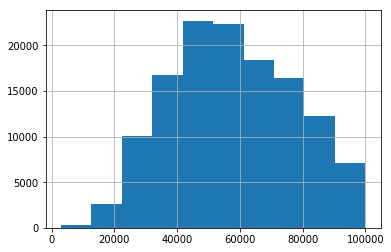

In [25]:
crosstab = pd.crosstab(index=df_numeric[df_numeric.annual_inc<100000]["annual_inc"],columns=df_categorical_copy["Target"])
plt.scatter(crosstab.index,crosstab[1]/((crosstab[0]+crosstab[1])))
plt.show()
plt.scatter(crosstab.index,crosstab[1])
plt.show()
df_numeric[df_numeric.annual_inc<100000]["annual_inc"].hist()
plt.show()

we can see no significent pattern of deliquency in the data for now, rather than the fact that most common percentage of deliquencys happens under 50% over the whole population

we can see that sense annual_inc value witch is 0.95 and above the chances to be in a delinquency is pretty equal

<b>4.3. the date:</b><br>issue_d for all the observations in the analysis

<b>4.4. the Identifier:</b><br>member_id for all the observations in the analysis

# Part B

## 1. Machine learning Algorithm

I decided to use a Random Forest Algorithm approch to deal with the business problem, because it is a classification problem and the spliting of the features in a smart way to all the possible posibilites is a good way to deal with outliers i the data, besides that the classification of RF is quite good on big amount of data

lets build the dataset that will use to solve the business problem

In [57]:
df_RF = pd.DataFrame(df[["Target","total_acc","issue_d","member_id","annual_inc"]])
# df_log = pd.DataFrame(df[["Target","total_acc","issue_d","member_id","int_rate"]])

df_RF["sub_grade"] = df_categorical_copy["sub_grade"]
df_RF["home_ownership"] = df_categorical_copy["home_ownership"]
df_RF = df_RF[(df_RF.annual_inc<=100000) & (df_RF.total_acc<=60)]
df_RF.head()

,Target,total_acc,issue_d,member_id,annual_inc,sub_grade,home_ownership
1,0,29,2017-09-14,31436395,41500.0,8,1
3,0,58,2017-09-14,30685592,67000.0,22,3
4,0,23,2017-09-14,22622030,54264.0,18,1
5,0,51,2017-09-14,30005666,56800.0,12,3
6,0,35,2017-09-14,30215519,51000.0,7,1


now i can split the data for modeleling, after viewing the data i realized that there are outliers for the annual_inc feature therefore i'll take only values which are lower then 100,000

In [58]:
X = df_RF[["total_acc","sub_grade","home_ownership","annual_inc"]]
y = df_RF["Target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

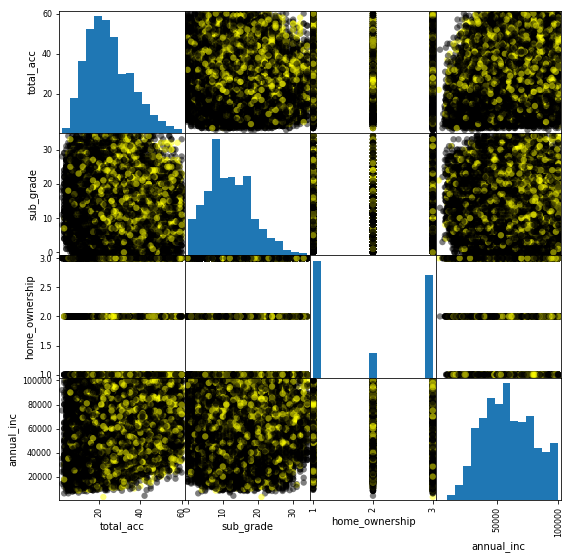

In [89]:
cmap = cm.get_cmap('gnuplot')
scatter = pd.plotting.scatter_matrix(X_train, c= y_train, marker = 'o', s=40, hist_kwds={'bins':15}, figsize=(9,9), cmap=cmap)
plt.show()

In [60]:
df_RF.corr()

,Target,total_acc,member_id,annual_inc,sub_grade,home_ownership
Target,1.000000,0.129155,-0.002017,0.076498,0.076990,-0.068357
total_acc,0.129155,1.000000,-0.002079,0.261770,-0.059664,-0.189235
member_id,-0.002017,-0.002079,1.000000,-0.010780,0.032379,0.021621
annual_inc,0.076498,0.261770,-0.010780,1.000000,-0.081116,-0.234823
sub_grade,0.076990,-0.059664,0.032379,-0.081116,1.000000,0.013014
home_ownership,-0.068357,-0.189235,0.021621,-0.234823,0.013014,1.000000


according to the scatter matrix and the corr matrix we can see there are no correlations and strong dependencies between the features<br><br>

##### Fitting the Random Forest algorithm and testing the results

In [61]:
rand_for = RandomForestClassifier(criterion='entropy')

In [62]:
rand_for.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [63]:
print("accuracy - train")
rand_for.score(X_train,y_train)

accuracy - train


0.9143524869176447

In [64]:
print("accuracy - test")
rand_for.score(X_test,y_test)

accuracy - test


0.74501615558129608

In [65]:
prediction = rand_for.predict(X_test)
conf_mat = pd.DataFrame(index=["real 0","real 1"],\
                        columns=["predicted 0","predicted 1"],data=confusion_matrix(y_test,prediction))
print("This is the confusion matrix:\n{}\n".format(conf_mat))

This is the confusion matrix:
        predicted 0  predicted 1
real 0        23573         2925
real 1         5440          868



C:\Users\user\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


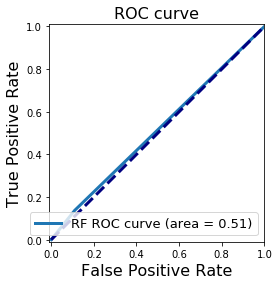

In [66]:
y_score_RF = rand_for.predict(X_test)
fpr_RF, tpr_RF, _ = roc_curve(y_test, y_score_RF)
roc_auc_RF = auc(fpr_RF, tpr_RF)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_RF, tpr_RF, lw=3, label='RF ROC curve (area = {:0.2f})'.format(roc_auc_RF))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


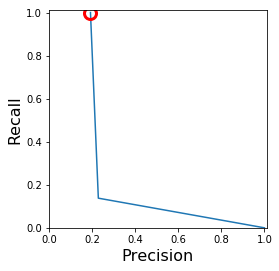

In [67]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_score_RF)
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.axes().set_aspect('equal')
plt.show()

In [53]:
from sklearn.model_selection import cross_val_score
# accuracy is the default scoring metric
print('Cross-validation (accuracy)', cross_val_score(rand_for, X_test, y_test, cv=5))
# use AUC as scoring metric
print('Cross-validation (AUC)', cross_val_score(rand_for, X_test, y_test, cv=5, scoring = 'roc_auc'))
# use recall as scoring metric
print('Cross-validation (recall)', cross_val_score(rand_for, X_test, y_test, cv=5, scoring = 'recall'))
# use recall as scoring metric
print('Cross-validation (precision)', cross_val_score(rand_for, X_test, y_test, cv=5, scoring = 'precision'))

print('Cross-validation (accuracy) AVG', np.mean(cross_val_score(rand_for, X_test, y_test, cv=5)))
# use AUC as scoring metric
print('Cross-validation (AUC) AVG', np.mean(cross_val_score(rand_for, X_test, y_test, cv=5, scoring = 'roc_auc')))
# use recall as scoring metric
print('Cross-validation (recall) AVG', np.mean(cross_val_score(rand_for, X_test, y_test, cv=5, scoring = 'recall')))
# use recall as scoring metric
print('Cross-validation (precision) AVG', np.mean(cross_val_score(rand_for, X_test, y_test, cv=5, scoring = 'precision')))

Cross-validation (accuracy) [ 0.76120085  0.75144773  0.76775373  0.76204268  0.76402439]
Cross-validation (AUC) [ 0.55516042  0.55497017  0.55605022  0.56249432  0.55884177]
Cross-validation (recall) [ 0.12044374  0.11172742  0.11489699  0.11022998  0.1221253 ]
Cross-validation (precision) [ 0.27751196  0.22742475  0.24257426  0.228471    0.25585023]
Cross-validation (accuracy) AVG 0.760653801265
Cross-validation (AUC) AVG 0.557655233186
Cross-validation (recall) AVG 0.113189667848
Cross-validation (precision) AVG 0.243297270441


### model description

<b>feature selection</b><br>
the feature selection was made by viewing the correlations between the features and the target variable, for more details view Part A segment again<br>
regardig the creation of the features the 2 numerical features was used as is because the algorithm groups the data, so i decided that no more data engineering was needed, and as for the 2 categorical features, i transformed them into numerical features as described in Part A in more details

<b>methodology</b><br>
I ran a RF algorithm with the default paraeters to see if i could get good results with the minimum amount of effort. <br>
i splited the data to a train and test segment for my ML algorithm and used cross-validation method with 5 folds to ran my algorithm

<b>model results</b><br>
the results of the model are not satisfying, this is the avarage of the 5 folds of the cross validation:<br>
accuracy: 0.756<br>
recall: 0.11<br>
precision: 0.245<br>
AUC: 0.556<br>

<b>conclusions</b><br>
this results showing that the model misses allot of delinquencies and, from the dlinquencies he does predict too many are not realy a delinquency, the accuracy is not that low, a value of 0.756 is not that bad, but still i got this value as a function of the population of end points which is near 20%, so this result alone is not good indicator of the model. for example a dummy clasifier would get 80% accuracy for predicting 0 for each observation.

## 2. Anomalies

I'll prepare the dataset for the anomaly detection as the original dataset before the filtering and after the transformations

In [90]:
df_ano = pd.DataFrame(df[["Target","total_acc","issue_d","member_id","annual_inc"]])
# df_log = pd.DataFrame(df[["Target","total_acc","issue_d","member_id","int_rate"]])

df_ano["sub_grade"] = df_categorical_copy["sub_grade"]
df_ano["home_ownership"] = df_categorical_copy["home_ownership"]

a. total_acc<br>

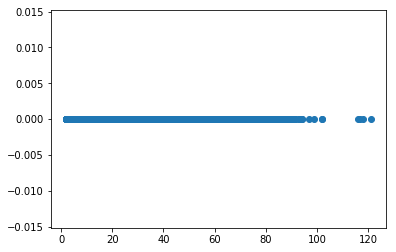

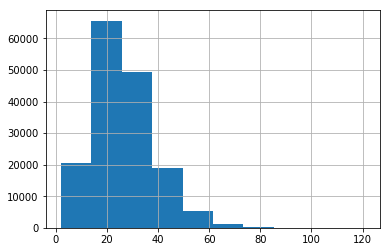

In [91]:
plt.scatter(df_ano["total_acc"],np.zeros(len(df_ano["total_acc"])))
plt.show()
df_ano["total_acc"].hist()
plt.show()

I can see that there is an anomaly for values over 60 in this feature

b. sub_grade<br>


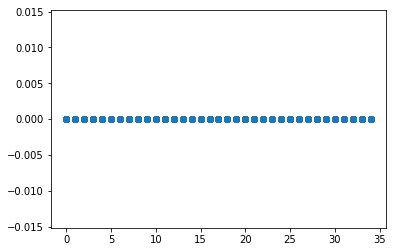

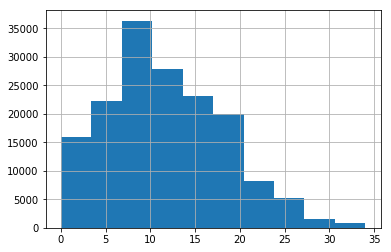

In [92]:
plt.scatter(df_ano["sub_grade"],np.zeros(len(df_ano["sub_grade"])))
plt.show()
df_ano["sub_grade"].hist()
plt.show()

I can see that there is an anomaly for values over 25 in this feature

c. annual_inc<br>

plt.scatter(df_ano["annual_inc"],np.zeros(len(df_ano["annual_inc"])))
plt.show()
df_ano["annual_inc"].hist()
plt.show()

I can see that there is an anomaly for values over 100,000 in this feature

## 3. Next Iteration features

I recommend to go back to the correlation matrix and find the next features which has high correlation to the target and to make sure that there is no correlation between the features to prevent a False high AUC indicator.<br>
i would choose to see the: <br>
int_rate, open_acc as numerical features and<br>
emp_length, is_inc_v as categrical features



## 4. Summary

In my research, I tried to prevent risk that could happen, because of delinquency therefore, I was looking to see if I could predict if borrower will be a cause of trouble later on.

<br>I saw that the model I build was not sufficient enough, perhaps more data would tell show a clearer pattern of borrowers that could get in to trouble, i assumed that the data is a prior to the loan given to I would not use data which is a result of the loan lifetime because I’m trying to see the trouble before it happens. <br>

because the model was not sufficient enough i would suggest gathering more data, and to try to predict on a more wider set of features and not only on 4 features, furthermore i would try test different ML algorithms and choose the one with the best performance. i would start off by trying different parameters in the Random Forest algorithms and not only using the default scikit-learn implementation
